In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd
from environment import Environment
import numpy as np
plt.rcParams.update({'font.size': 18})

In [3]:
# Paths of models to evalute
# environment = Environment(Path(f"./environments/dilemma"), groups_file='./groups.txt')
# constraints = ForwardConstraints(environment.grid_x_size, environment.grid_y_size, environment.existing_lines_full, environment.grid_to_vector)
models = ['dilemma_5x5_20220503_13_58_29.563962', 'dilemma_5x5_20220503_17_47_23.454216', 'dilemma_5x5_20220419_13_22_47.509481', 
            'dilemma_5x5_20220418_17_43_08.080415', 'dilemma_5x5_20220503_15_18_36.055557', 'dilemma_5x5_20220503_16_36_50.970871']

lines, group_ginis, group_pct_ginis, group_ods, group_ods_pct, group_pct_diff = [], [], [], [], [], []
for model_path in models:
    with open(Path('result', model_path, 'result_metrics.json')) as json_file:
        data = json.load(json_file)
        lines.append(data['avg_generated_line'])
        group_ods.append(data['mean_sat_group_od'])
        group_ods_pct.append(data['mean_sat_group_od_pct'])
        group_ginis.append(0.5-data['group_gini'])
        group_pct_ginis.append(0.5-data['group_pct_gini'])
        group_pct_diff.append(1-abs(data['mean_sat_od_by_group_pct'][0] - data['mean_sat_od_by_group_pct'][1]))



FileNotFoundError: [Errno 2] No such file or directory: 'result/dilemma_5x5_20220503_13_58_29.563962/result_metrics.json'

In [4]:
metrics = pd.DataFrame(zip(models, lines, group_ods, group_ods_pct, group_ginis, group_pct_ginis, group_pct_diff), 
                columns=['model', 'line', 'group_od', 'group_ods_pct', 'group_gini', 'group_pct_gini', 'group_pct_diff'])

metrics

,model,line,group_od,group_ods_pct,group_gini,group_pct_gini,group_pct_diff


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 0.

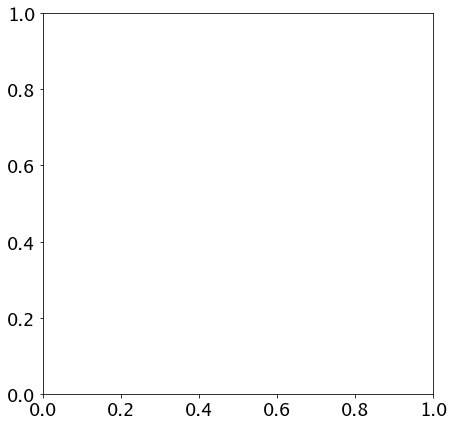

In [5]:
# To create a scatterplot with different custom markers.
# From https://github.com/matplotlib/matplotlib/issues/11155
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)

metrics_plot = metrics.drop_duplicates(['group_ods_pct', 'group_gini'])
fig, ax = plt.subplots(figsize=(7, 7))
s = np.repeat(400, metrics_plot.shape[0])
m = ['o','^', 's']
c = ['y', '#FF99CC', '#FF0000']

scatter = mscatter(metrics_plot['group_ods_pct'], metrics_plot['group_pct_diff'], c=c, s=s, m=m, ax=ax)
ax.set_xlabel('% of total satisfied OD flows', fontsize=18)
ax.set_ylabel('Equity of benefits (1-difference)', fontsize=18)
fig.suptitle('Utility vs Equity - Dilemma Environment')
ax.set_ylim((0.25,1))
ax.set_xlim((0.25,1))

In [6]:
metrics.drop_duplicates(['group_ods_pct', 'group_gini'])

,model,line,group_od,group_ods_pct,group_gini,group_pct_gini,group_pct_diff


In [7]:
# fig, ax = plt.subplots(figsize=(5, 5))

# ax.scatter(metrics.drop_duplicates(['group_ods_pct', 'group_gini'])['group_ods_pct'], metrics.drop_duplicates(['group_ods_pct', 'group_gini'])['group_pct_diff'])
# ax.set_xlabel('% of total satisfied OD flows')
# ax.set_ylabel('Equity of benefits (1-difference)')
# fig.suptitle('Utility vs Equity - Dilemma Environment')
# ax.set_ylim((0,1))
# ax.set_xlim((0,1))

# # for i, txt in enumerate(models):
# #     ax.annotate(txt, (group_ods_pct[i], group_pct_ginis[i]))

(0.0, 1.0)

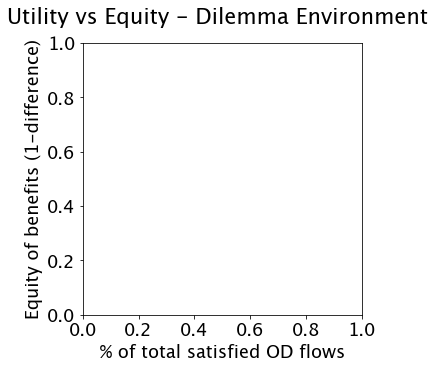

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(group_ods_pct, group_pct_diff, alpha=0.5)
ax.set_xlabel('% of total satisfied OD flows')
ax.set_ylabel('Equity of benefits (1-difference)')
fig.suptitle('Utility vs Equity - Dilemma Environment')
ax.set_ylim((0,1))
ax.set_xlim((0,1))

# for i, txt in enumerate(models):
#     ax.annotate(txt, (group_ods_pct[i], group_pct_ginis[i]))

c:\Users\Dimitris\Documents\GitHub\fair-network-expansion\environment.py:58: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



Text(0.5, 1.0, 'Aggregate Origin-Destination Flow')

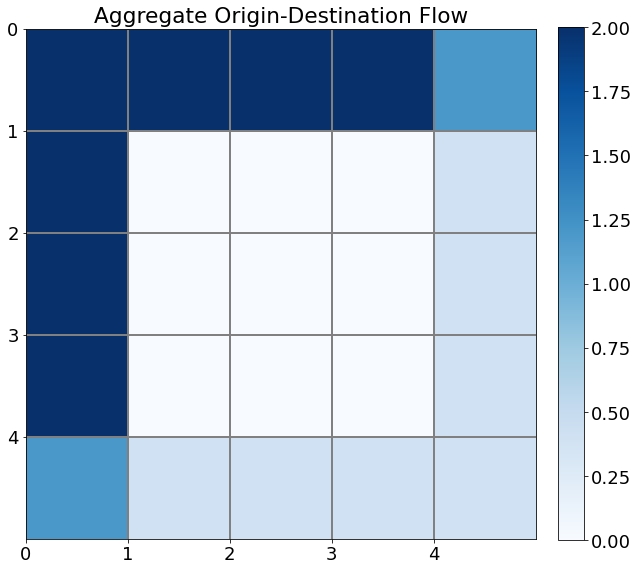

In [236]:
# TODO: transfer this method to the environment class.
import torch
from matplotlib import cm
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dilemma = Environment(Path(f"./environments/dilemma_5x5"))

def calculate_agg_od(environment):
    """Calculate aggregate origin-destination flow matrix for each grid square of the given environment.

    Args:
        environment (Environment): environment for which to calcualte aggregate OD per grid square.

    Returns:
        torch.Tensor: aggregate od by grid
    """
    # 
    # A measure of importance of each square.
    agg_od_g = torch.zeros((environment.grid_x_size, environment.grid_y_size)).to(device)
    agg_od_v = environment.od_mx.sum(axis=1)
    # Get the grid indices.
    for i in range(agg_od_v.shape[0]):
        g = environment.vector_to_grid(torch.Tensor([i])).type(torch.int32)
        agg_od_g[g[0], g[1]] = agg_od_v[i]

    return agg_od_g

dilemma_od = calculate_agg_od(dilemma).cpu()
fig, ax = plt.subplots(figsize=(10, 10))

im0 = ax.imshow(dilemma_od, cm.get_cmap('Blues'))
ax.set_xticks(np.arange(-.5, 4, 1))
ax.set_yticks(np.arange(-.5, 4, 1))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))
ax.grid(color='gray', linewidth=2)
# cax = fig.add_axes([0.65, 0.175, 0.2, 0.02])
fig.colorbar(im0, orientation='vertical', fraction=0.046, pad=0.04)
ax.set_title('Aggregate Origin-Destination Flow')


# # for i, l in enumerate(metrics.drop_duplicates(['group_ods_pct', 'group_gini'])['line']):
# for i, l in enumerate(metrics.drop_duplicates(['group_ods_pct', 'group_gini']).iloc[0:1]['line']):
#     # Sort the pairs in such a way to make a continuous connected line
#     print(l)
#     l_sorted = sorted(l, key=lambda x: x[0], reverse=True)

#     l_g = list(zip(*l_sorted))
#     ax.plot(l_g[1], l_g[0], '-ok')
#     # axs[1].plot(l_v[1], l_v[0], '-or', label=label)


In [164]:
metrics.drop_duplicates(['group_ods_pct', 'group_gini'])

,model,line,group_od,group_ods_pct,group_gini,group_pct_gini,group_pct_diff
0,dilemma_5x5_20220503_13_58_29.563962,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0...",9.0,0.825688,0.111111,0.285223,0.420760
3,dilemma_5x5_20220503_13_57_24.615759,"[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [4, 1...",5.0,0.458716,0.160000,0.378132,0.801668
5,dilemma_5x5_20220503_15_18_36.055557,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4...",5.6,0.513761,0.285714,0.439189,0.866543
6,dilemma_5x5_20220503_16_36_50.970871,"[[0, 2], [0, 3], [0, 4], [1, 2], [2, 2], [3, 2...",3.6,0.330275,0.388889,0.329873,0.726599
